In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from Uno.Game import Game

## Manually Simulate a Game
(for your fun/leisure)  
this code is also used to debug game rules

In [2]:
from Players.WDSRVCW4_Player import WDSRVCW4_Player

In [3]:
# set up the players
players = [WDSRVCW4_Player(), WDSRVCW4_Player(), WDSRVCW4_Player(), WDSRVCW4_Player()]

# create a game (with 381 as the random seed)
#   change the random seed to get a new game

#   when the seed is 787 and all 4 players are WDSRVCW4_Player
#       the game lasts a long time
game = Game(players, 381)
print(game)


Deck: [BLUE N5,GREEN N9,YELLOW N3,RED N8,YELLOW N1]
Discard: []

Turn: 0
0:	7 [YELLOW N6,YELLOW N5,YELLOW DRAW2,RED N2,GREEN N0,RED N7,GREEN N6]
1:	7 [BLUE N4,GREEN N1,YELLOW N9,BLUE N2,BLUE N0,BLUE N2,BLUE N1]
2:	7 [GREEN N5,BLUE N3,GREEN N2,GREEN DRAW2,BLUE N4,GREEN N2,YELLOW N5]
3:	7 [BLUE DRAW2,RED N1,RED N1,BLUE SKIP,YELLOW N2,RED REV,BLUE REV]
        


In [4]:
# run the setup step
game.setup_round()
print(game)


Deck: [GREEN N9,YELLOW N3,RED N8,YELLOW N1,YELLOW N4]
Discard: [BLUE N5]

Turn: 0
0:	7 [YELLOW N6,YELLOW N5,YELLOW DRAW2,RED N2,GREEN N0,RED N7,GREEN N6]
1:	7 [BLUE N4,GREEN N1,YELLOW N9,BLUE N2,BLUE N0,BLUE N2,BLUE N1]
2:	7 [GREEN N5,BLUE N3,GREEN N2,GREEN DRAW2,BLUE N4,GREEN N2,YELLOW N5]
3:	7 [BLUE DRAW2,RED N1,RED N1,BLUE SKIP,YELLOW N2,RED REV,BLUE REV]
        


In [5]:
# to play more rounds:
#  please re-run this cell until a player runs out of cards

# play rounds until a winner emerges
winner = game.round()
print(game)
if winner != -1:
    print('WINNER: ', winner)


Deck: [GREEN N9,YELLOW N3,RED N8,YELLOW N1,YELLOW N4]
Discard: [YELLOW N5,BLUE N5]

Turn: 1
0:	6 [YELLOW DRAW2,YELLOW N6,RED N2,GREEN N0,RED N7,GREEN N6]
1:	7 [BLUE N4,GREEN N1,YELLOW N9,BLUE N2,BLUE N0,BLUE N2,BLUE N1]
2:	7 [GREEN N5,BLUE N3,GREEN N2,GREEN DRAW2,BLUE N4,GREEN N2,YELLOW N5]
3:	7 [BLUE DRAW2,RED N1,RED N1,BLUE SKIP,YELLOW N2,RED REV,BLUE REV]
        


# Sampling

In [6]:
from Players.DSRVCW4W_Player import DSRVCW4W_Player
from Players.DSRCVW4W_Player import DSRCVW4W_Player
from Players.DSRCW4WV_Player import DSRCW4WV_Player
from Players.DSRCW4VW_Player import DSRCW4VW_Player

In [7]:
N_SAMPLES = 10000
N_EXPERIMENTS = 10

In [8]:
def play_game(your_strategy, opponent_strategy, n_players=4):
    # set up the players
    players = [None]*n_players
    players[0] = your_strategy()
    for i in range(1, n_players):
        players[i] = opponent_strategy()
    # create a game
    #   no seed for maximum randomness
    game = Game(players, None)
    game.setup_round()
    # play rounds until a winner emerges
    winner = game.round()
    while winner == -1:
        winner = game.round()
    return winner

### Plot 10 Time Series of Win %s

In [9]:
def win_percent_ts(your_strategy, opponent_strategy, n_players=4,
                   n_samples=100, n_series=10):
    percents = np.zeros((n_series, n_samples))

    for ser in range(n_series):
        your_wins = 0
        for i in range(n_samples):
            if play_game(your_strategy, opponent_strategy, n_players) == 0:
                your_wins += 1
            percents[ser, i] = your_wins/(i+1)

    return percents

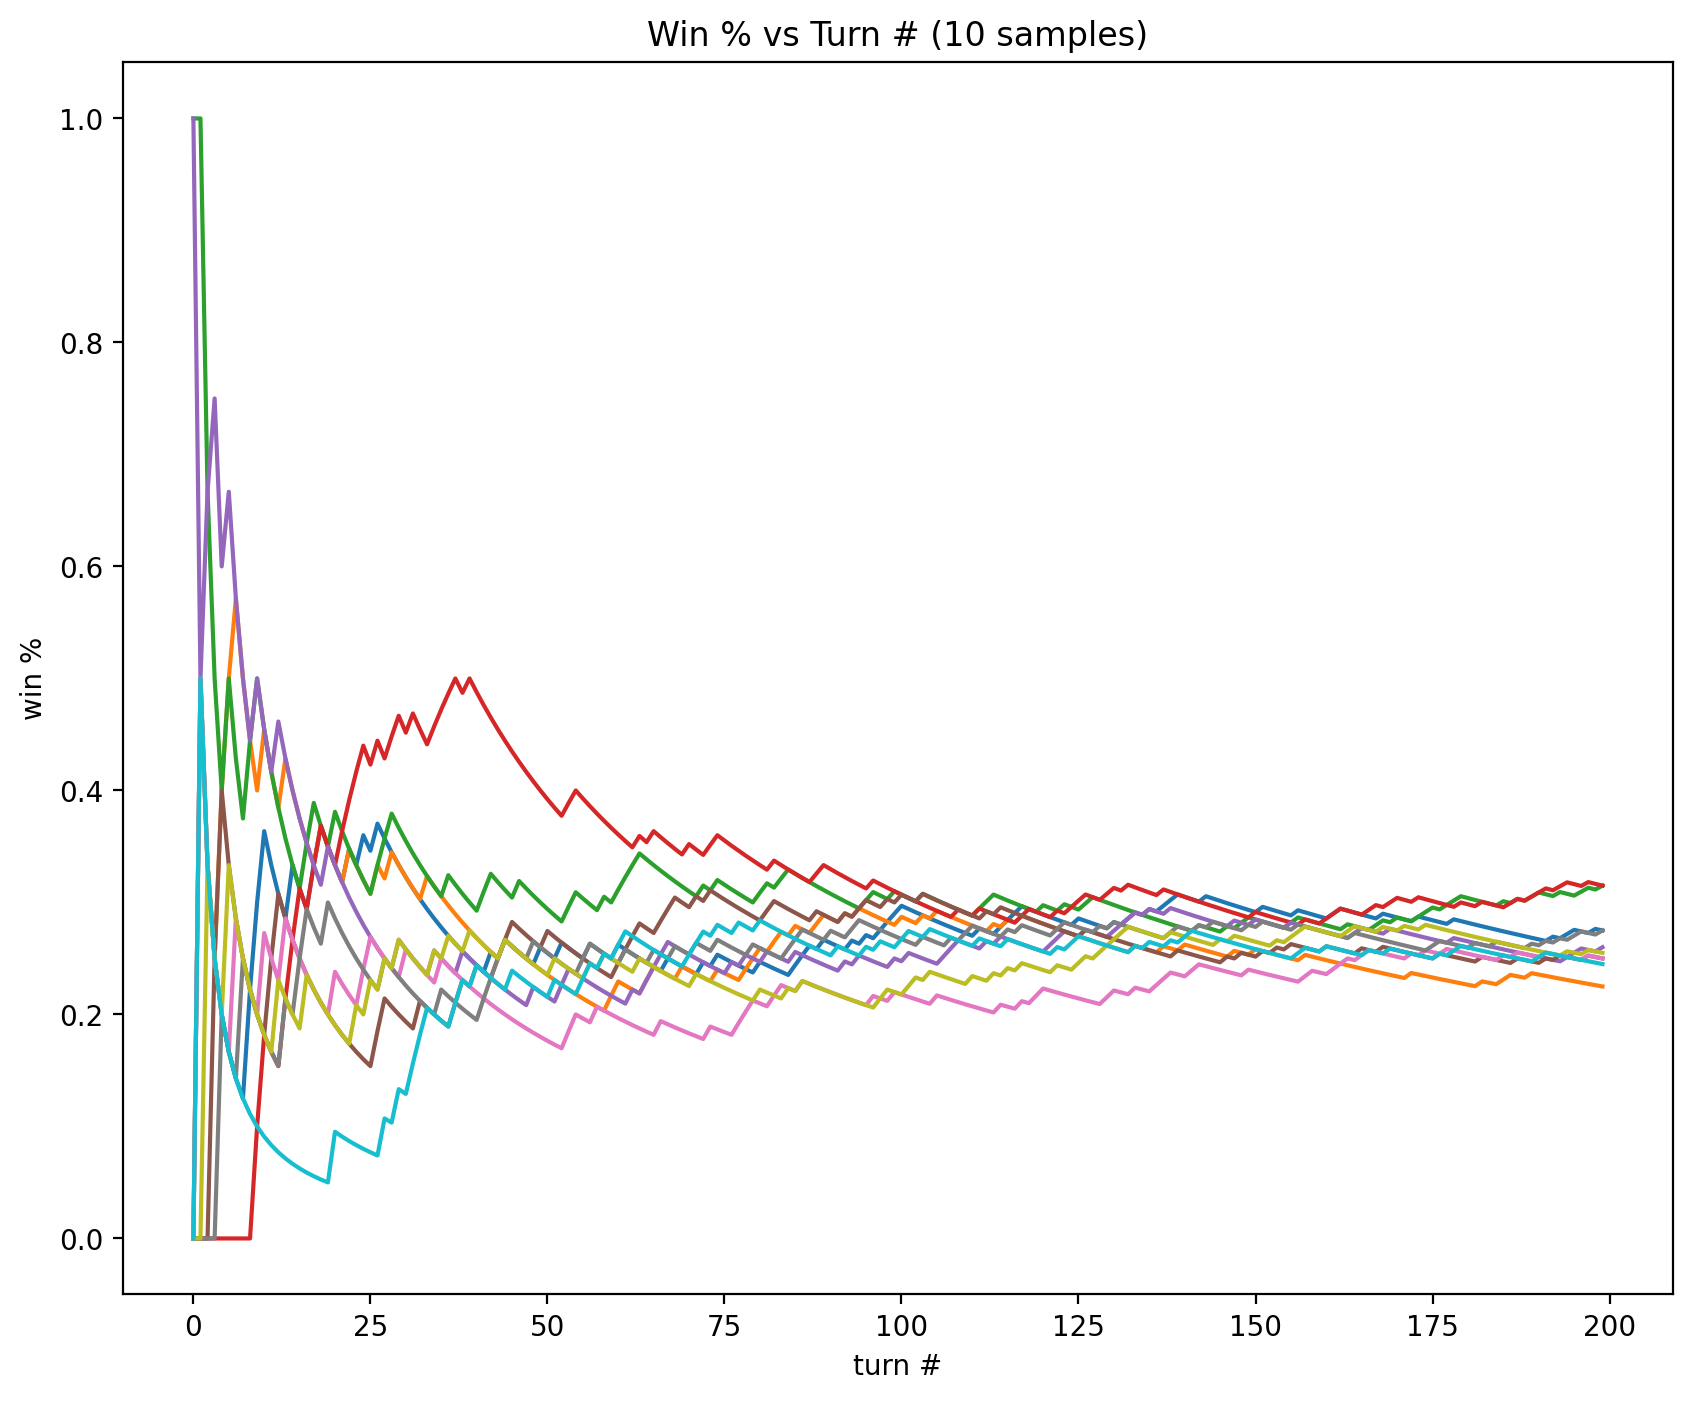

In [19]:
# noinspection PyUnreachableCode
if False:
    ts_percents = win_percent_ts(DSRCVW4W_Player, DSRCW4WV_Player, n_samples=200)
    plt.figure(figsize=(10, 8), dpi=200)
    plt.xlabel('turn #')
    plt.ylabel('win %')
    plt.title('Win % vs Turn # (10 samples)')
    for i in range(ts_percents.shape[0]):
        plt.plot(ts_percents[i, :])
    plt.savefig('win_perc_10.png');

In [11]:
def win_percent(your_strategy, opponent_strategy, n_players=4, n_samples=N_SAMPLES):
    your_wins = 0
    for _ in range(n_samples):
        if play_game(your_strategy, opponent_strategy, n_players) == 0:
            your_wins += 1
    return your_wins/n_samples

In [12]:
def win_percent_hist(your_strategy, opponent_strategy, n_players=4,
                   n_samples=1000, n_games=1000):
    hist = np.zeros((n_samples, ))

    for i in tqdm.trange(n_samples):
        hist[i] = win_percent(your_strategy, opponent_strategy, n_players, n_games)

    return hist

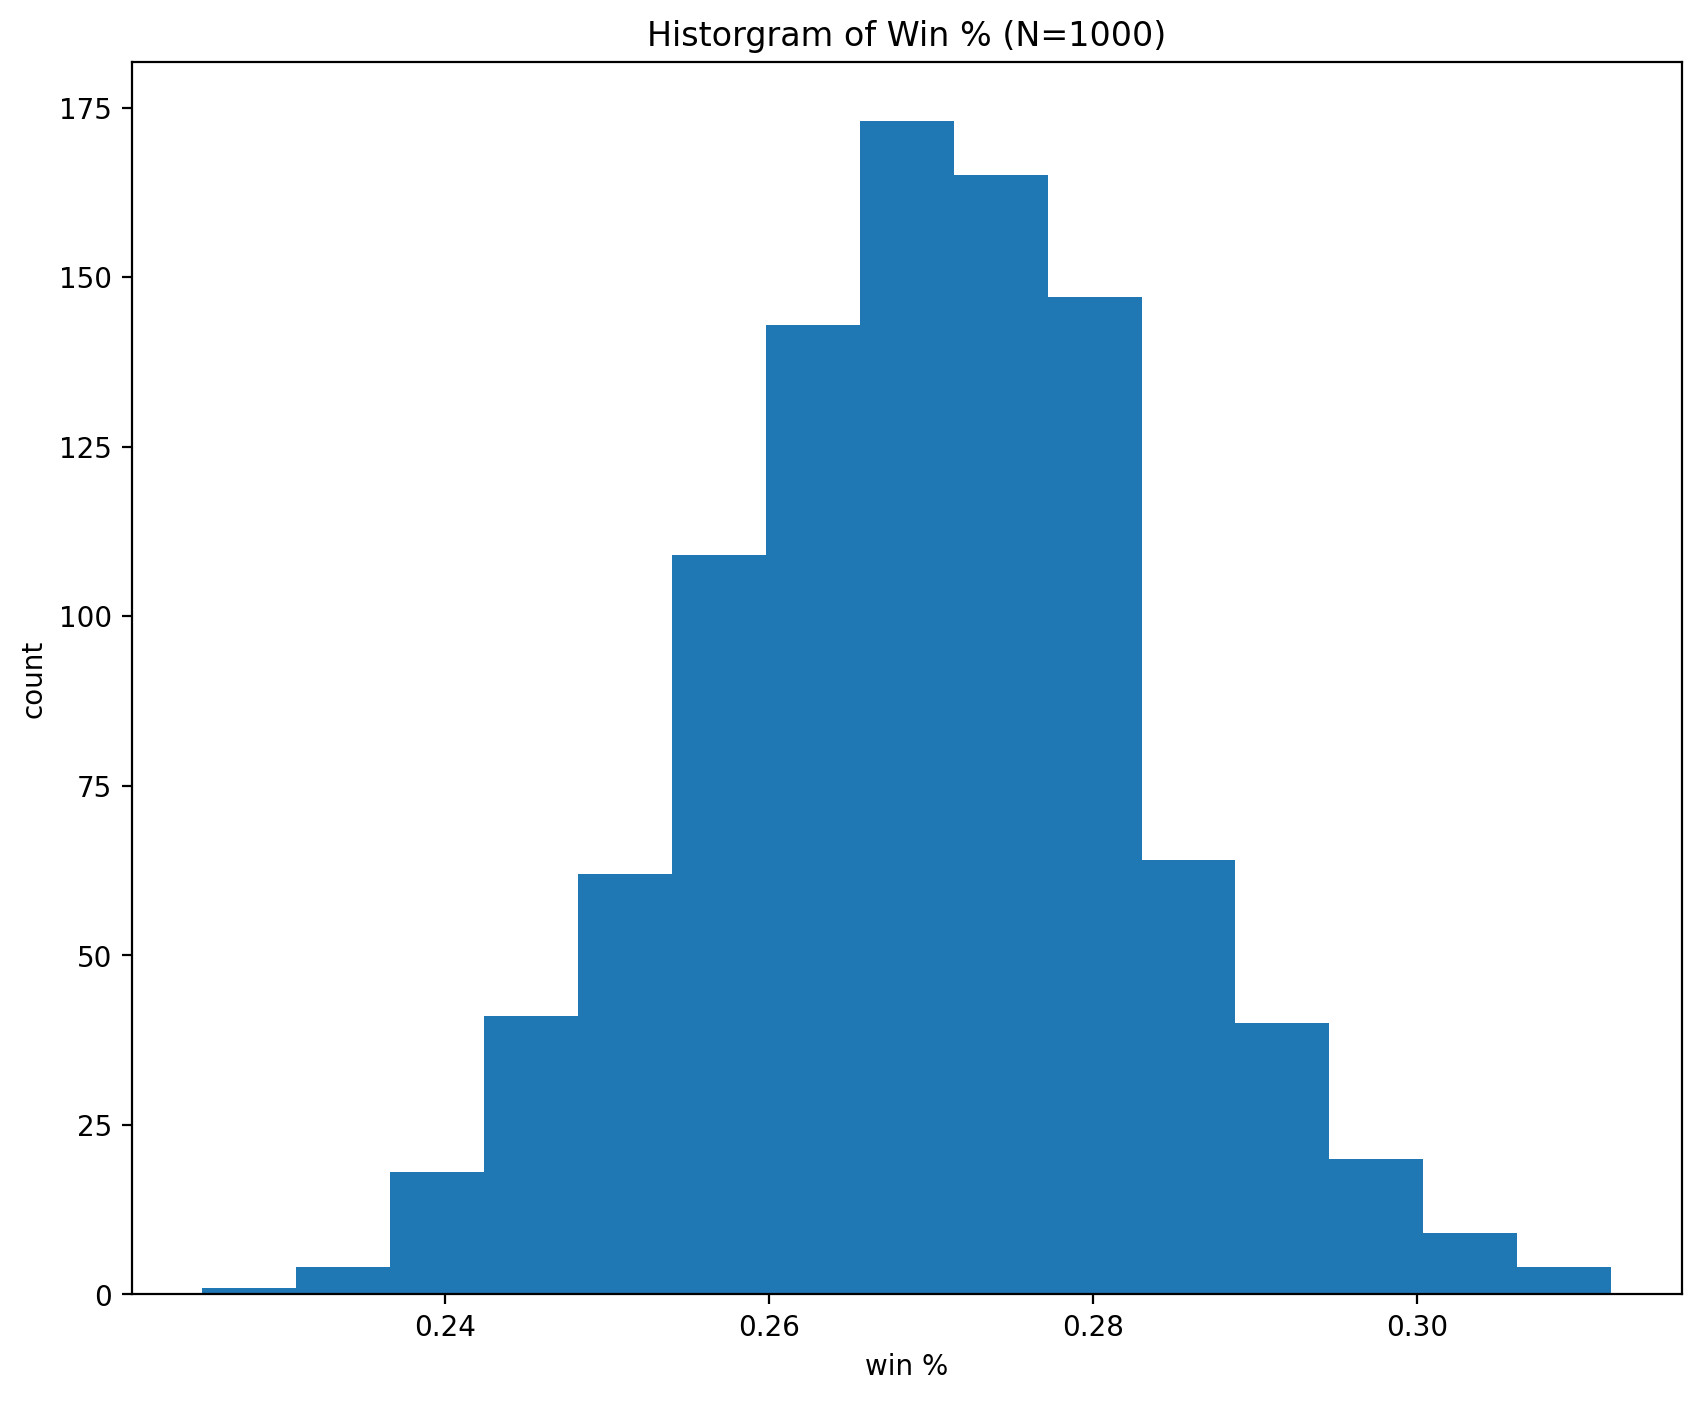

In [16]:
# noinspection PyUnreachableCode
if False:
    win_perct_hist = win_percent_hist(DSRCVW4W_Player, DSRCW4WV_Player)
    plt.figure(figsize=(10, 8), dpi=200)
    plt.xlabel('win %')
    plt.ylabel('count')
    plt.title('Historgram of Win % (N=1000)')
    plt.hist(win_perct_hist, bins=15)
    plt.savefig('clt_hist.png');

In [14]:
def win_percent_ci(your_strategy, opponent_strategy, n_players=4, n_samples=N_SAMPLES, n_exprs=N_EXPERIMENTS):
    expr_percents = np.zeros(n_exprs)

    for i in range(n_exprs):
        expr_percents[i] = win_percent(your_strategy, opponent_strategy, n_players, n_samples)

    mean_percent = np.mean(expr_percents)
    moe = 2**(-n_exprs+1)
    return (mean_percent-moe, mean_percent+moe)

In [15]:
# round, str concat two float columns as interval
def make_CI_str_col(r, lo_col='low_prct', hi_col='high_prct'):
    r['CI'] = f'({round(r[lo_col], 3):.3f}, {round(r[hi_col], 3):.3f})'
    return r

In [16]:
def simulate_games(my_player_list, opp_player_list,
                   my_strat_names, opp_strat_names,
                   out_file):
    for i, my_player in enumerate(my_player_list):
        for j, opp_player in enumerate(tqdm.tqdm((opp_player_list))):
                # save names of strategies at play
                my_strat_list.append(my_strat_names[i])
                opp_strat_list.append(opp_strat_names[j])
                # simulate 10 runs of 10K games and get a CI
                low_perct, high_prct = win_percent_ci(my_player, opp_player)
                # save CI
                low_perct_list.append(low_perct)
                high_perct_list.append(high_prct)

    results_df = pd.DataFrame(
        {
            'my_strat':my_strat_list,
            'opp_strat':opp_strat_list,
            'low_prct':low_perct_list,
            'high_prct':high_perct_list
        }
    )
    # make a 'str' type column for the CI
    results_df = results_df.apply(make_CI_str_col, axis=1)
    # pivot the DF so we have 1 col/opponent strategy, 1 row/our strategy, 1 cell/CI
    basic_results_df = results_df.pivot(index='my_strat', columns='opp_strat', values='CI')

    # save results
    basic_results_df.to_csv(out_file)

In [17]:
my_strategy_names = ['DSRVCW4W', 'DSRCVW4W', 'DSRCW4WV', 'DSRCW4VW']
opp_strategy_names = ['DSRVCW4W', 'DSRCVW4W', 'DSRCW4WV', 'DSRCW4VW']
my_strat_list, opp_strat_list = [], []
low_perct_list, high_perct_list = [], []

# analysis results in './Results/basic_results.csv'
#   analysis took 65m 10sec
simulate_games(
    (DSRVCW4W_Player, DSRCVW4W_Player, DSRCW4WV_Player, DSRCW4VW_Player),
    (DSRVCW4W_Player, DSRCVW4W_Player, DSRCW4WV_Player, DSRCW4VW_Player),
    my_strategy_names,
    opp_strategy_names,
    'Results/basic_results.csv'
)

100%|██████████| 4/4 [04:51<00:00, 72.89s/it]
